#### Introduction

The purpose of this project is to explore Quantile Trading Strategies coupled with a beta neutral position.

The first step of this process is to filter the universe of stocks to stocks with ample data and satisfying additional requirements. Those requirements are given as follows - 

- The strategy shall be employed over the period of Jan 2011 through Jan 2018
- EOD Adjusted closing prices are avilable for the security
- The debt to market cap ratio is greater than 0.1 at least once over the investment period
- The stock does not belong to automotive, financial or insurance sector
- The data is available regarding total debt, book value per share & diluted net earnings per share, no more than one year old
- Market return is approximated by SPY ETF

Once this universe of securities is defined, we choose 200 stocks with largest average daily volume. 


__Assumptions :__ zero trading cost, all securities are easy to borrow, trading fractional shares & arbitrary positions sizes are possible, portfolio capital is equal to gross notional


In [604]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import quandl
import functools
import os
import pickle
from pyfinance import ols
plt.style.use('ggplot')
import pandas_datareader.data as dr
import statsmodels.api as sm

In [605]:
import warnings
warnings.filterwarnings('ignore')

In [606]:
mpl.rcParams["figure.figsize"] = (8, 6)

**Import data from quandl**

In [311]:
quandl.ApiConfig.api_key = "ksPPvPR9UxF5mZNeFgNT" 
@functools.lru_cache(maxsize=1600)
def fetch_quandl(securities, start, end, returns="pandas"):
    qdata = quandl.get(list(securities), returns=returns, trim_start=start, trim_end = end)
    return qdata

**Clean the data from quandl**

In [312]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = asset +":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

**How to get the tickers**

__1)__   Download the condensed data from Zacks Fundamentals B in excel files and combine them in a dataframe
<br>
__2)__   Extract the columns of interest
<br>
__3)__   Extract only quarterly data lying within the start_date and end_date

In [313]:
start_date = '2011-01-03'
end_date = '2017-12-31'

In [574]:
libor = dr.DataReader("USD3MTD156N", "fred", start=start_date, end=end_date)/300

In [314]:
sheet1 = pd.read_csv(r'ZFB-complete/ZFB-1.csv', sep='|')
sheet2 = pd.read_csv(r'ZFB-complete/ZFB-2.csv', sep='|')
sheet3 = pd.read_csv(r'ZFB-complete/ZFB-3.csv', sep='|')
sheet4 = pd.read_csv(r'ZFB-complete/ZFB-4.csv', sep='|')
sheet5 = pd.read_csv(r'ZFB-complete/ZFB-5.csv', sep='|')
sheet6 = pd.read_csv(r'ZFB-complete/ZFB-6.csv', sep='|')

In [315]:
cols_of_interest = ['TICKER','PER_TYPE','PER_END_DATE','TOT_DEBT_TOT_EQUITY','NET_CURR_DEBT','TOT_LTERM_DEBT','NBR_SHARES_OUT','BOOK_VAL_PER_SHARE', 'DILUTED_NET_EPS','ZACKS_SECTOR_CODE']

In [316]:
all_tickers = pd.concat([sheet1[cols_of_interest], sheet2[cols_of_interest], sheet3[cols_of_interest],
                         sheet4[cols_of_interest], sheet5[cols_of_interest], sheet6[cols_of_interest]])
                         
all_tickers = all_tickers[all_tickers['PER_TYPE'] == 'Q']
all_tickers = all_tickers[(all_tickers['ZACKS_SECTOR_CODE'] != 5) & (all_tickers['ZACKS_SECTOR_CODE'] != 13)]
all_tickers = all_tickers[(all_tickers['PER_END_DATE'] > start_date) & (all_tickers['PER_END_DATE'] < end_date)]

In [317]:
potential_tickers = all_tickers.TICKER.unique()

In [318]:
len(potential_tickers)

8626

In [319]:
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['NBR_SHARES_OUT']].apply(lambda x: x.isna().any())
potential_tickers = temp_df[temp_df['NBR_SHARES_OUT'] == False].index

In [320]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

3725

In [321]:
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['TOT_DEBT_TOT_EQUITY']].apply(lambda x: x.isna().any())
potential_tickers = temp_df[temp_df['TOT_DEBT_TOT_EQUITY'] == False].index

In [322]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

2251

In [323]:
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['TOT_DEBT_TOT_EQUITY']].apply(lambda x: x.max() >= 0.1)
potential_tickers = temp_df[temp_df['TOT_DEBT_TOT_EQUITY'] == True].index

In [324]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

2041

In [325]:
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['BOOK_VAL_PER_SHARE']].apply(lambda x: x.isna().any())
potential_tickers = temp_df[temp_df['BOOK_VAL_PER_SHARE'] == False].index

In [326]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

1957

In [327]:
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['DILUTED_NET_EPS']].apply(lambda x: x.isna().any())
potential_tickers = temp_df[temp_df['DILUTED_NET_EPS'] == False].index

In [328]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

1164

In [329]:
if os.path.isfile("adjclose_raw_data.pkl"): 
    with open("adjclose_raw_data.pkl", "br") as f:
        adj_close_df = pickle.load(f)
    print("Raw data read from 'adjclose_raw_data.pkl'.")
else:
    adj_close_df = pd.DataFrame(index = pd.date_range(start_date, end_date))
    for ticker in potential_tickers:
        try:
            raw_data = fetch_quandl(('EOD/{}.11'.format(ticker),), start_date, end_date)
            clean_data = clean_quandl_columns(raw_data)
        except:
            print('{} not found'.format(ticker))
            continue

        try:
            if (clean_data['{}:Adj_Close'.format(ticker)].isna().any()) or (str(clean_data.index[0]).split()[0] != str(start_date)):
                print('{} does not have all Adj Close Data'.format(ticker))
                continue
        except:
            print('{} does not have any Adj Close Data'.format(ticker))
            continue
            
        adj_close_df[ticker] = clean_data['{}:Adj_Close'.format(ticker)]
        
    with open("adjclose_raw_data.pkl", "bw") as f:
        pickle.dump(adj_close_df, f)
    print("Raw data written to 'adjclose_raw_data.pkl'.")

Raw data read from 'adjclose_raw_data.pkl'.


In [330]:
print("{} number of tickers satisy all the requirements".format(len(adj_close_df.columns.unique())))

1061 number of tickers satisy all the requirements


**Randomly select 200 tickers**

In [331]:
select_adj_close_df = adj_close_df.iloc[:,600:800].dropna()
select_adj_close_df.reset_index(inplace=True)

In [373]:
select_adj_close_df.head()

,index,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
0,2011-01-03,16.475256,59.103706,27.228215,66.337077,13.11,34.580,17.568502,9.098150,17.263522,...,60.936245,27.026681,8.570904,40.721451,4.95,2.96,2.0400,33.820,20.300940,7.436072
1,2011-01-04,16.243828,57.336767,27.173429,66.905334,12.62,34.420,16.716696,8.783698,17.225364,...,60.856031,26.086694,8.587661,41.284538,4.90,2.91,2.0384,33.255,20.162426,7.386576
2,2011-01-05,16.283729,57.606823,27.251694,67.380435,12.73,34.785,17.024292,9.066705,17.187207,...,61.141238,26.144924,8.922789,41.728183,4.92,3.00,2.0600,33.290,20.292283,7.452492
3,2011-01-06,16.100183,57.259608,27.408223,69.737306,12.63,34.650,17.296397,9.150559,17.045479,...,60.143013,25.005294,8.989815,40.832362,4.99,3.02,2.0580,34.310,20.647225,7.504099
4,2011-01-07,16.191956,57.383063,27.376917,68.936156,12.44,34.280,17.544841,9.182004,17.001871,...,58.868495,24.947065,9.014949,40.943273,5.00,2.98,2.0200,34.100,20.777081,7.342241


**Create a dataframe of financial ratios for selected tickers**

In [333]:
fin_ratios_df = all_tickers[all_tickers['TICKER'].isin(select_adj_close_df.columns)]
fin_ratios_df['NET_CURR_DEBT'] = fin_ratios_df['NET_CURR_DEBT'].fillna(0)
fin_ratios_df['TOT_LTERM_DEBT'] = fin_ratios_df['TOT_LTERM_DEBT'].fillna(0)
fin_ratios_df['PER_END_DATE'] = pd.to_datetime(fin_ratios_df['PER_END_DATE'])

In [334]:
len(fin_ratios_df.TICKER.unique())

200

In [335]:
fin_ratios_df.head()

,TICKER,PER_TYPE,PER_END_DATE,TOT_DEBT_TOT_EQUITY,NET_CURR_DEBT,TOT_LTERM_DEBT,NBR_SHARES_OUT,BOOK_VAL_PER_SHARE,DILUTED_NET_EPS,ZACKS_SECTOR_CODE
2174,RDNT,Q,2011-03-31,-6.2820,0.0,500.3070,37319720.0,-2.1934,-0.02,4.0
2175,RDNT,Q,2011-06-30,-6.7643,0.0,508.5720,37426460.0,-2.0592,0.09,4.0
2176,RDNT,Q,2011-09-30,-6.8773,0.0,512.0480,37426460.0,-2.0356,0.00,4.0
2177,RDNT,Q,2011-12-31,-8.0053,0.0,545.3840,37426460.0,-1.8652,0.12,4.0
2178,RDNT,Q,2012-03-31,-8.1316,0.0,545.5421,38225480.0,-1.7928,0.00,4.0


In [336]:
fin_ratios_df = fin_ratios_df[['TICKER','PER_END_DATE','NET_CURR_DEBT','TOT_LTERM_DEBT',
                               'NBR_SHARES_OUT','BOOK_VAL_PER_SHARE','DILUTED_NET_EPS']]

In [337]:
final_tickers = select_adj_close_df.columns[1:]

In [338]:
fin_ratios_df.rename(columns={'TICKER':'ticker', 'PER_END_DATE':'date'}, inplace=True)
fin_ratios_df.set_index(['ticker', 'date'], inplace=True)

In [339]:
fin_ratios_df.head()

NET_CURR_DEBT  TOT_LTERM_DEBT  NBR_SHARES_OUT  \
ticker date                                                        
RDNT   2011-03-31            0.0        500.3070      37319720.0   
       2011-06-30            0.0        508.5720      37426460.0   
       2011-09-30            0.0        512.0480      37426460.0   
       2011-12-31            0.0        545.3840      37426460.0   
       2012-03-31            0.0        545.5421      38225480.0   

                   BOOK_VAL_PER_SHARE  DILUTED_NET_EPS  
ticker date                                             
RDNT   2011-03-31             -2.1934            -0.02  
       2011-06-30             -2.0592             0.09  
       2011-09-30             -2.0356             0.00  
       2011-12-31             -1.8652             0.12  
       2012-03-31             -1.7928             0.00

In [340]:
dates = pd.date_range(start_date, end_date)
len(dates)

2555

In [341]:
final_finratio_df = pd.DataFrame(columns=['ticker', 'date'])
for ticker in final_tickers:
    final_finratio_df = final_finratio_df.append(pd.DataFrame(data={'ticker': [ticker]*len(dates), 'date': dates}))
final_finratio_df.set_index(['ticker', 'date'], inplace=True)

In [342]:
final_finratio_df = pd.merge(fin_ratios_df, final_finratio_df, how='outer', left_index=True, right_index=True)
final_finratio_df.head()

NET_CURR_DEBT  TOT_LTERM_DEBT  NBR_SHARES_OUT  \
ticker date                                                        
MATX   2011-01-03            NaN             NaN             NaN   
       2011-01-04            NaN             NaN             NaN   
       2011-01-05            NaN             NaN             NaN   
       2011-01-06            NaN             NaN             NaN   
       2011-01-07            NaN             NaN             NaN   

                   BOOK_VAL_PER_SHARE  DILUTED_NET_EPS  
ticker date                                             
MATX   2011-01-03                 NaN              NaN  
       2011-01-04                 NaN              NaN  
       2011-01-05                 NaN              NaN  
       2011-01-06                 NaN              NaN  
       2011-01-07                 NaN              NaN

In [343]:
pivot_adj_close_df = pd.melt(select_adj_close_df, id_vars=['index'], value_vars=select_adj_close_df.columns[1:])
pivot_adj_close_df.rename(columns={'index':'date', 'variable':'ticker', 'value':'adj close price'}, inplace=True)
pivot_adj_close_df.set_index(['ticker', 'date'], inplace=True)
pivot_adj_close_df.head()

adj close price
ticker date                       
MATX   2011-01-03        16.475256
       2011-01-04        16.243828
       2011-01-05        16.283729
       2011-01-06        16.100183
       2011-01-07        16.191956

We have financial ratios(final_finratio_df) at quarterly frequency and adjusted close prices(pivot_adj_close_df) at daily frequency. We are going to convert financial ratios into daily frequency using daily adjusted close prices.  

We are going to work with these three financial ratios

__Debt To Market Cap__ = $\frac{\text{Total Debt}}{\text{Market Cap}} = \frac{\text{Net Curr Debt + Total Long Term Debt}}{\text{Outstanding Shares*Adjusted Close Price}}$
<br>
<br>
__Price to Book__ = $\frac{\text{Adj close price}}{\text{Book value per share}}$
<br>
<br>
__Price to Earnings__ = $\frac{\text{Adj close price}}{\text{Diluted net earnings per share}}$

In [344]:
merged_df = pd.merge(final_finratio_df, pivot_adj_close_df, how='outer', left_index=True, right_index=True)

In [345]:
merged_df.head()

NET_CURR_DEBT  TOT_LTERM_DEBT  NBR_SHARES_OUT  \
ticker date                                                        
MATX   2011-01-03            NaN             NaN             NaN   
       2011-01-04            NaN             NaN             NaN   
       2011-01-05            NaN             NaN             NaN   
       2011-01-06            NaN             NaN             NaN   
       2011-01-07            NaN             NaN             NaN   

                   BOOK_VAL_PER_SHARE  DILUTED_NET_EPS  adj close price  
ticker date                                                              
MATX   2011-01-03                 NaN              NaN        16.475256  
       2011-01-04                 NaN              NaN        16.243828  
       2011-01-05                 NaN              NaN        16.283729  
       2011-01-06                 NaN              NaN        16.100183  
       2011-01-07                 NaN              NaN        16.191956

In [346]:
merged_df = pd.merge(final_finratio_df, pivot_adj_close_df, how='outer', left_index=True, right_index=True)
merged_df = merged_df.groupby('ticker').ffill().drop(columns='ticker')
merged_df.reset_index(level='ticker', inplace=True)
merged_df = merged_df[merged_df.index.dayofweek < 5].dropna()

In [362]:
merged_df.head()

,ticker,NET_CURR_DEBT,TOT_LTERM_DEBT,NBR_SHARES_OUT,BOOK_VAL_PER_SHARE,DILUTED_NET_EPS,adj close price,debt_to_marketcap,price_to_book,price_to_earnings
date,,,,,,,,,,
2011-03-31,MATX,-5.0,374.0,41591460.0,27.2896,0.12,18.280425,0.485329,0.669868,152.336874
2011-04-01,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.812371,0.406742,0.799292,181.769760
2011-04-04,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.576107,0.411196,0.790635,179.800893
2011-04-05,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.467986,0.413267,0.786673,178.899887
2011-04-06,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.259754,0.417315,0.779042,177.164615


In [348]:
merged_df['debt_to_marketcap'] = 1000000*(merged_df['NET_CURR_DEBT'] + merged_df['TOT_LTERM_DEBT']
                                 )/(merged_df['NBR_SHARES_OUT']*merged_df['adj close price'])

merged_df['price_to_book'] = merged_df['adj close price']/merged_df['BOOK_VAL_PER_SHARE']

merged_df['price_to_earnings'] = merged_df['adj close price']/merged_df['DILUTED_NET_EPS']

In [349]:
merged_df.head()

,ticker,NET_CURR_DEBT,TOT_LTERM_DEBT,NBR_SHARES_OUT,BOOK_VAL_PER_SHARE,DILUTED_NET_EPS,adj close price,debt_to_marketcap,price_to_book,price_to_earnings
date,,,,,,,,,,
2011-03-31,MATX,-5.0,374.0,41591460.0,27.2896,0.12,18.280425,0.485329,0.669868,152.336874
2011-04-01,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.812371,0.406742,0.799292,181.769760
2011-04-04,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.576107,0.411196,0.790635,179.800893
2011-04-05,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.467986,0.413267,0.786673,178.899887
2011-04-06,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.259754,0.417315,0.779042,177.164615


In [356]:
debt_to_marketcap = merged_df[['ticker','debt_to_marketcap']].reset_index().pivot(index='date', columns='ticker', values='debt_to_marketcap')
debt_to_marketcap.dropna(inplace=True)
debt_to_marketcap = debt_to_marketcap.resample('M').last()
debt_to_marketcap.head()

ticker,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
date,,,,,,,,,,,,,,,,,,,,,
2011-03-31,0.485329,0.178352,0.061297,0.192762,0.0,0.096999,1.427202,1.019539,0.835576,0.178420,...,0.174070,0.356449,0.284714,1.057316,0.834239,3.830277,0.104737,0.039013,0.433278,0.234395
2011-04-30,0.420403,0.173296,0.056771,0.183566,0.0,0.091104,1.239451,1.028741,0.780103,0.181089,...,0.169568,0.407956,0.285648,1.095551,0.867032,3.662833,0.103754,0.034350,0.435710,0.231123
2011-05-31,0.451001,0.165197,0.058425,0.177991,0.0,0.085976,1.330350,0.923069,0.749319,0.188348,...,0.186255,0.382694,0.366660,1.118586,0.859777,2.816380,0.104737,0.029211,0.469442,0.244378
2011-06-30,0.632269,0.169812,0.061194,0.185399,0.0,0.026257,1.450782,0.940656,0.692295,0.160348,...,0.187200,0.419237,0.510313,1.133563,1.857331,3.088311,0.106603,0.030688,0.417891,0.242350
2011-07-31,0.631613,0.165570,0.068737,0.191181,0.0,0.027809,1.581038,0.850688,0.709411,0.167224,...,0.206157,0.473637,0.495847,1.393445,1.942726,3.623618,0.118770,0.032799,0.464070,0.242406


In [354]:
price_to_book = merged_df[['ticker','price_to_book']].reset_index().pivot(index='date', columns='ticker', values='price_to_book')
price_to_book.dropna(inplace=True)
price_to_book = price_to_book.resample('M').last()
price_to_book.head()

ticker,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
date,,,,,,,,,,,,,,,,,,,,,
2011-03-31,0.669868,4.249257,3.111034,2.576121,1.340275,2.125901,0.901442,4.243540,0.808788,1.291442,...,1.764157,1.323104,0.903623,0.922751,1.023676,-1.595696,5.004744,7.869989,0.580943,1.102234
2011-04-30,0.773319,4.373233,3.359033,2.705171,1.476880,2.263457,1.037992,4.205584,0.866301,1.272406,...,1.810991,1.156055,0.900666,0.890547,0.984959,-1.668642,5.052182,8.938234,0.577700,1.117840
2011-05-31,0.720854,4.587645,3.263964,2.789902,1.201093,2.398460,0.967069,4.687032,0.901892,1.223365,...,1.648745,1.232366,0.701668,0.872208,0.993270,-2.170147,5.004744,10.510831,0.536189,1.057205
2011-06-30,0.711925,4.559574,3.035199,2.784288,1.304071,2.211703,0.923863,4.979710,0.882579,1.168328,...,1.562792,1.150169,0.713930,0.834946,0.751594,-2.136752,4.841757,10.859824,0.444498,1.076102
2011-07-31,0.712664,4.676376,2.702136,2.700077,1.442722,2.088235,0.847749,5.506357,0.861285,1.120289,...,1.419082,1.018065,0.734758,0.679226,0.718557,-1.821096,4.345772,10.160858,0.400267,1.075856


In [355]:
price_to_earnings = merged_df[['ticker','price_to_earnings']].reset_index().pivot(index='date', columns='ticker', values='price_to_earnings')
price_to_earnings.dropna(inplace=True)
price_to_earnings = price_to_earnings.resample('M').last()
price_to_earnings.head()

ticker,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
date,,,,,,,,,,,,,,,,,,,,,
2011-03-31,152.336874,51.470693,47.981179,45.560449,115.555556,70.861702,-43.058184,-42.870639,38.340166,32.149583,...,66.620453,42.086591,182.884262,83.813069,-45.909091,-175.000000,-52.75,-91.714286,75.037658,22.084356
2011-04-30,175.863160,52.972401,51.806040,47.842794,127.333333,75.446809,-49.580607,-42.487180,41.066523,31.675680,...,68.389058,36.772933,182.285819,80.887940,-44.172727,-183.000000,-53.25,-104.163265,74.618766,22.397034
2011-05-31,163.931718,55.569545,50.339803,49.341303,103.555556,79.946809,-46.192914,-47.351040,42.753686,30.454844,...,62.262106,39.200309,142.010587,79.222242,-44.545455,-238.000000,-52.75,-122.489796,69.256938,21.182146
2011-06-30,43.969136,48.950914,61.084932,69.281714,47.454545,62.773913,-30.267788,360.385513,35.536331,30.446816,...,67.967796,40.633841,34.462353,74.681489,5.986842,48.888889,-205.00,-82.188406,27.895156,292.038671
2011-07-31,44.014785,50.204875,54.381864,67.186284,52.500000,59.269565,-27.774135,398.499374,34.678940,29.194907,...,61.717650,35.966800,35.467738,60.753114,5.723684,41.666667,-184.00,-76.898551,25.119382,291.971890


In [396]:
spy_adj_close = fetch_quandl(('EOD/SPY.11',), start_date, end_date)
bdates = spy_adj_close.index

monthly_spy_adj_close = spy_adj_close.resample('M').last()
monthly_spy_adj_close = monthly_spy_adj_close.loc[positions.index]
monthly_spy_adj_close.rename(columns={'EOD/SPY - Adj_Close':'val'}, inplace=True)
monthly_spy_adj_close.head()

,val
date,
2011-03-31,111.690164
2011-04-30,114.924872
2011-05-31,113.636043
2011-06-30,111.717393
2011-07-31,109.482538


In [401]:
stocks_adj_close_df = select_adj_close_df.rename(columns={'index':'Date'}).set_index('Date')
stocks_adj_close_df = stocks_adj_close_df.loc[bdates]
stocks_adj_close_df.head()

,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,16.475256,59.103706,27.228215,66.337077,13.11,34.580,17.568502,9.098150,17.263522,22.373121,...,60.936245,27.026681,8.570904,40.721451,4.95,2.96,2.0400,33.820,20.300940,7.436072
2011-01-04,16.243828,57.336767,27.173429,66.905334,12.62,34.420,16.716696,8.783698,17.225364,22.385638,...,60.856031,26.086694,8.587661,41.284538,4.90,2.91,2.0384,33.255,20.162426,7.386576
2011-01-05,16.283729,57.606823,27.251694,67.380435,12.73,34.785,17.024292,9.066705,17.187207,23.036492,...,61.141238,26.144924,8.922789,41.728183,4.92,3.00,2.0600,33.290,20.292283,7.452492
2011-01-06,16.100183,57.259608,27.408223,69.737306,12.63,34.650,17.296397,9.150559,17.045479,22.861262,...,60.143013,25.005294,8.989815,40.832362,4.99,3.02,2.0580,34.310,20.647225,7.504099
2011-01-07,16.191956,57.383063,27.376917,68.936156,12.44,34.280,17.544841,9.182004,17.001871,22.617192,...,58.868495,24.947065,9.014949,40.943273,5.00,2.98,2.0200,34.100,20.777081,7.342241


In [405]:
rolling_reg = ols.RollingOLS(x=stocks_adj_close_df, y=spy_adj_close, window=20)
rolling_betas = pd.DataFrame(data=rolling_reg.beta, index=stocks_adj_close_df.index[19:], 
                             columns=stocks_adj_close_df.columns)
rolling_betas = rolling_betas.resample('M').last()
rolling_betas.head()

,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,3096.0,278.00,298.0,164.000,-190.0,-558.0,-672.0,-1004.0,1172.0,-203.0,...,0.0,-48.0,-44.0,-29.0,-304.0,-128.0,-208.0,-26.000,92.0,496.0
2011-02-28,2283.5,-1038.50,1740.0,-386.375,-2496.0,558.0,-844.0,-4118.0,228.0,184.0,...,1.5,3.0,-56.0,0.0,80.0,72.0,288.0,-33.000,-26.0,-8.0
2011-03-31,-202.0,157.00,246.0,-90.500,-108.0,134.0,158.0,96.0,-1246.0,511.0,...,4.0,0.0,-48.0,-10.0,-32.0,53.0,-224.0,-9.750,15.0,32.0
2011-04-30,26.0,421.75,239.5,178.500,-614.0,-153.0,664.0,491.0,-1160.0,109.0,...,22.5,35.0,-56.0,-1.5,102.0,-316.0,848.0,5.375,44.0,-298.0
2011-05-31,-9200.0,15552.00,-7872.0,-10240.000,7936.0,10304.0,256.0,-1312.0,-33288.0,10432.0,...,60.0,16.0,-320.0,192.0,-896.0,121.0,-768.0,1.500,-288.0,256.0


In [462]:
total_cap = 1000000 # Total investment capital is 1 million

In [670]:
def strategy(finratio_df, stocks_adjclose_df, spy_adjclose_df, rolling_betas, variable_position=False):
    
    quantiles_df = finratio_df.transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=1)
    if variable_position == False:
        positions_df = pd.DataFrame(data=np.where(quantiles_df == 0, 1, np.where(quantiles_df == 9, -1, 0)), 
                         index=finratio_df.index, columns=finratio_df.columns)
    else:
        positions_df = pd.DataFrame(data=1-2*quantiles_df/9, index=finratio_df.index, columns=finratio_df.columns)
    
    monthly_stocks_adjclose_df = stocks_adjclose_df.resample('M').last()
    monthly_stocks_adjclose_df = monthly_stocks_adjclose_df.loc[positions_df.index]
    
    total_pos = abs(positions_df).sum(axis=1) + abs(rolling_betas*positions_df).sum(axis=1)
    weights = total_cap/total_pos
    
    equity_ret = (((monthly_stocks_adjclose_df/monthly_stocks_adjclose_df.shift(1) - 1) 
                   * positions_df.shift(1)).sum(axis=1) * weights.shift(1))
    
    spy_positions = pd.DataFrame((-positions_df * rolling_betas).sum(axis=1), columns=['val'])
    spy_ret = ((spy_adjclose_df/spy_adjclose_df.shift(1) - 1) * spy_positions.shift(1)).sum(axis=1) * weights.shift(1)
    
    returns_df = pd.DataFrame(index = finratio_df.index, columns = ['equity_pnl','spy_pnl','gross_pnl','cum_gross_pnl'])
    
    returns_df['equity_pnl'] = equity_ret
    returns_df['spy_pnl'] = spy_ret
    returns_df['gross_pnl'] = returns_df['equity_pnl'] + returns_df['spy_pnl']
    returns_df['cum_gross_pnl'] = returns_df['gross_pnl'].cumsum()
    
    return returns_df

We will employ a strategy which is a combination of the two financial ratios, debt-to-market and price-to-book. The strategy works like this - 

- If a stock lies in the top decile of debt-to-market and bottom decile of price-to-book, we will buy it.
- If a stock lies in the bottom decile of debt-to-market and top decile of price-to-book, we will short it. 
- Else, take no position.

In [558]:
def combo_strategy(finratio_df1, finratio_df2, stocks_adjclose_df, spy_adjclose_df, rolling_betas):
    
    quantiles_df1 = finratio_df1.transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=1)
    quantiles_df2 = finratio_df2.transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=1)
    positions_df = pd.DataFrame(data=np.where((quantiles_df1 == 9) & (quantiles_df2 == 0), 1, np.where(
        (quantiles_df1 == 0) & (quantiles_df2 == 9), -1, 0)), index=finratio_df1.index, columns=finratio_df1.columns)
    
    monthly_stocks_adjclose_df = stocks_adjclose_df.resample('M').last()
    monthly_stocks_adjclose_df = monthly_stocks_adjclose_df.loc[positions_df.index]
    
    total_pos = abs(positions_df).sum(axis=1) + abs(rolling_betas*positions_df).sum(axis=1)
    weights = total_cap/total_pos
    
    equity_ret = (((monthly_stocks_adjclose_df/monthly_stocks_adjclose_df.shift(1) - 1) 
                   * positions_df.shift(1)).sum(axis=1) * weights.shift(1))
    
    spy_positions = pd.DataFrame((-positions_df * rolling_betas).sum(axis=1), columns=['val'])
    spy_ret = ((spy_adjclose_df/spy_adjclose_df.shift(1) - 1) * spy_positions.shift(1)).sum(axis=1) * weights.shift(1)
    
    returns_df = pd.DataFrame(index = finratio_df1.index, columns = ['equity_pnl','spy_pnl','gross_pnl','cum_gross_pnl'])
    
    returns_df['equity_pnl'] = equity_ret
    returns_df['spy_pnl'] = spy_ret
    returns_df['gross_pnl'] = returns_df['equity_pnl'] + returns_df['spy_pnl']
    returns_df['cum_gross_pnl'] = returns_df['gross_pnl'].cumsum()
    
    return returns_df

In [588]:
def stats(df, strategy):
    df.dropna(inplace=True)
    stats = pd.DataFrame(columns=['vol','sharpe_ratio','max_drawdown','cum_profit'], data=[[0,0,0,0]])
    
    stats.rename(index={0:'{}'.format(strategy)}, inplace=True)
    
    returns = (df['gross_pnl'].fillna(0) + total_cap).pct_change()
    vol = returns.std()
    SR = (returns.mean() - libor['USD3MTD156N'].mean())/returns.std()
    max_drawdown = ((df['gross_pnl'] + total_cap) - (df['gross_pnl'] + total_cap).cummax()).min()
    
    stats['vol'] = vol
    stats['sharpe_ratio'] = SR
    stats['max_drawdown'] = max_drawdown
    stats['cum_profit'] = df['gross_pnl'].cumsum()[-1]
                        
    return stats.transpose()

In [562]:
dtm_returns_df = strategy(debt_to_marketcap, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
ptb_returns_df = strategy(price_to_book, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
pte_returns_df = strategy(price_to_earnings, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
combo_returns_df = combo_strategy(price_to_book, debt_to_marketcap, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)

In [589]:
dtm_stats = stats(dtm_returns_df, 'debt-to-market')
ptb_stats = stats(ptb_returns_df, 'price-to-book')
pte_stats = stats(pte_returns_df, 'price-to-earnings')
combo_stats = stats(combo_returns_df, 'combination')

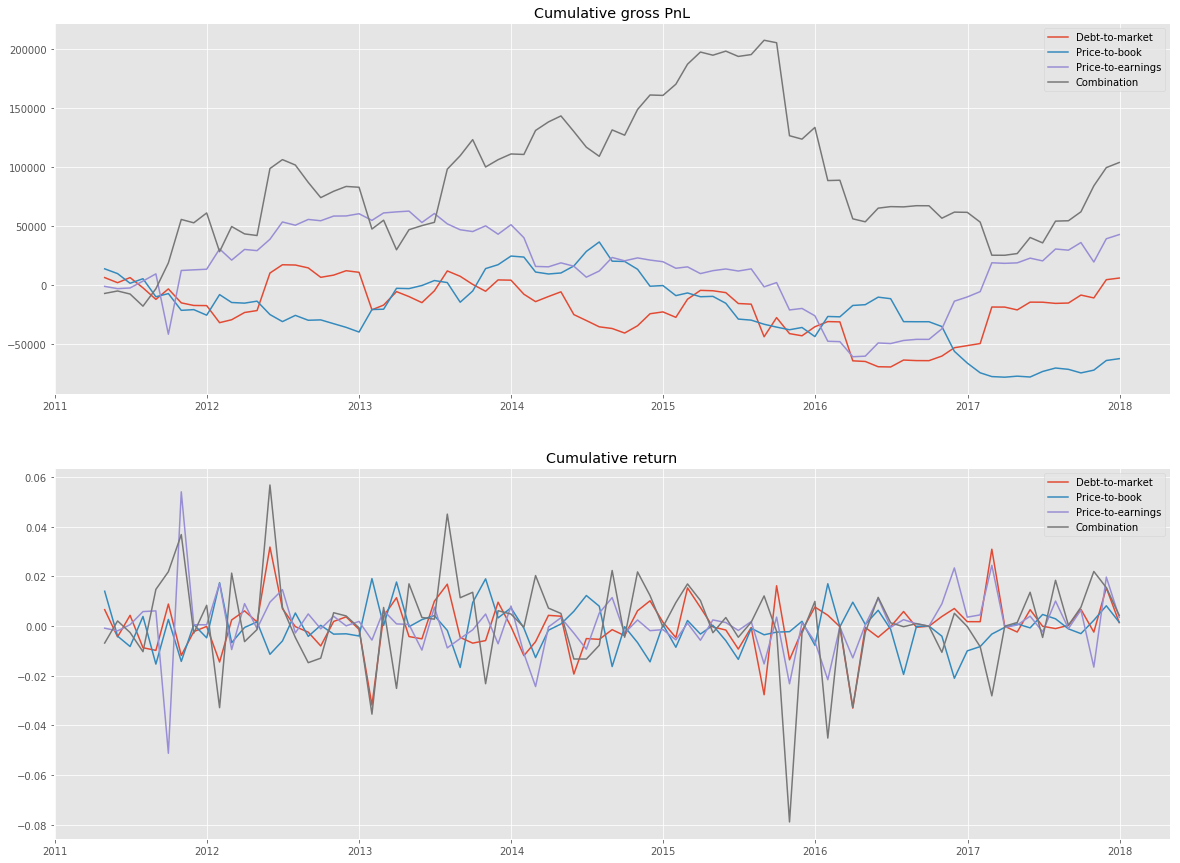

In [564]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
ax1.plot(dtm_returns_df[['cum_gross_pnl']], label="Debt-to-market")
ax1.plot(ptb_returns_df[['cum_gross_pnl']], label="Price-to-book")
ax1.plot(pte_returns_df[['cum_gross_pnl']], label="Price-to-earnings")
ax1.plot(combo_returns_df[['cum_gross_pnl']], label="Combination")
ax1.set_title("Cumulative gross PnL")
ax1.legend()

ax2.plot(np.cumprod(1+(dtm_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Debt-to-market")
ax2.plot(np.cumprod(1+(ptb_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Price-to-book")
ax2.plot(np.cumprod(1+(pte_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Price-to-earnings")
ax2.plot(np.cumprod(1+(combo_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Combination")
ax2.set_title("Cumulative return")
ax2.legend()

plt.show()

In [590]:
pd.concat([dtm_stats, ptb_stats, pte_stats, combo_stats], axis=1)

,debt-to-market,price-to-book,price-to-earnings,combination
vol,0.015034,0.011715,0.019794,0.026131
sharpe_ratio,-0.110615,-0.153361,-0.074022,-0.047213
max_drawdown,-64841.487183,-40120.291842,-78380.008281,-135622.401142
cum_profit,6225.336623,-62134.337031,43079.135349,104193.289994


In [671]:
dtm_v_returns_df = strategy(debt_to_marketcap, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas, True)
ptb_v_returns_df = strategy(price_to_book, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas, True)
pte_v_returns_df = strategy(price_to_earnings, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas, True)

In [672]:
dtm_v_stats = stats(dtm_v_returns_df, 'debt-to-market')
ptb_v_stats = stats(ptb_v_returns_df, 'price-to-book')
pte_v_stats = stats(pte_v_returns_df, 'price-to-earnings')

In [723]:
(np.cumprod(1+(dtm_v_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1)['gross_pnl']

date
2011-04-30         NaN
2011-05-31    0.000371
2011-06-30    0.005561
2011-07-31   -0.002414
2011-08-31   -0.003339
2011-09-30   -0.009301
2011-10-31   -0.017304
2011-11-30   -0.001885
2011-12-31   -0.002379
2012-01-31   -0.000141
2012-02-29    0.001797
2012-03-31    0.002984
2012-04-30    0.000476
2012-05-31    0.017297
2012-06-30    0.000773
2012-07-31   -0.001468
2012-08-31   -0.004452
2012-09-30   -0.001926
2012-10-31   -0.000637
2012-11-30    0.000825
2012-12-31   -0.000318
2013-01-31   -0.017975
2013-02-28    0.001387
2013-03-31    0.002585
2013-04-30   -0.001838
2013-05-31   -0.004147
2013-06-30    0.007092
2013-07-31    0.015239
2013-08-31   -0.009482
2013-09-30    0.004665
                ...   
2015-07-31   -0.003049
2015-08-31   -0.010783
2015-09-30    0.008984
2015-10-31   -0.011802
2015-11-30   -0.001800
2015-12-31    0.003160
2016-01-31    0.000056
2016-02-29   -0.000852
2016-03-31   -0.013103
2016-04-30   -0.000749
2016-05-31   -0.004986
2016-06-30   -0.001000
2016-0

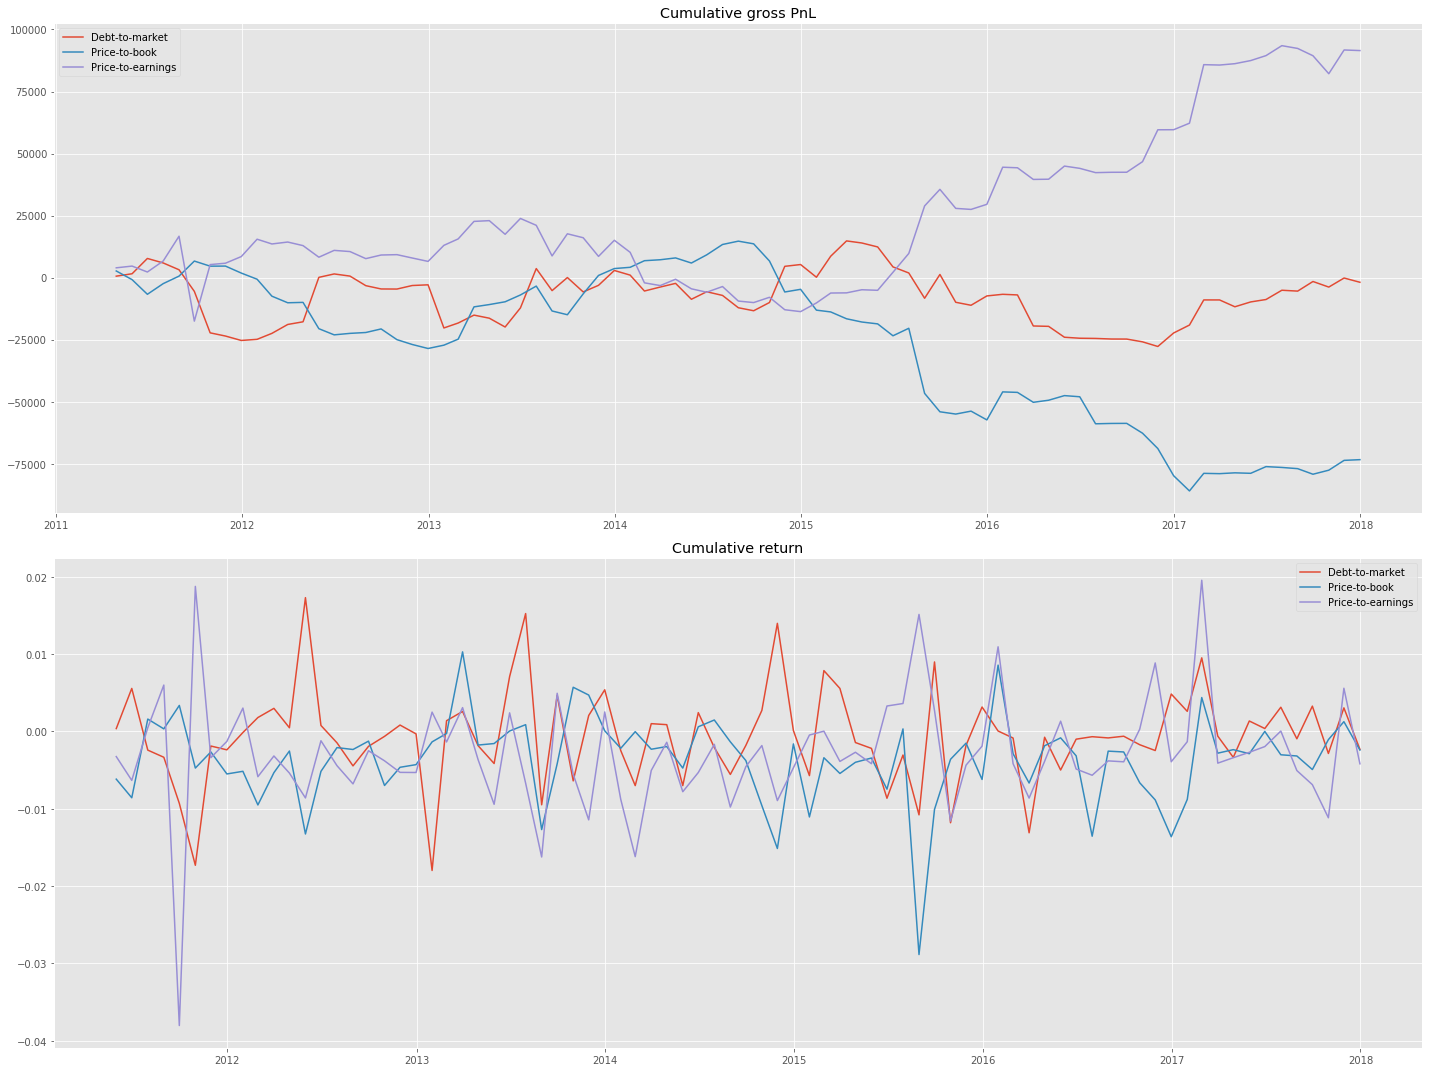

In [739]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
ax1.plot(dtm_v_returns_df[['cum_gross_pnl']], label="Debt-to-market")
ax1.plot(ptb_v_returns_df[['cum_gross_pnl']], label="Price-to-book")
ax1.plot(pte_v_returns_df[['cum_gross_pnl']], label="Price-to-earnings")
ax1.set_title("Cumulative gross PnL")
ax1.legend()

ax2.plot(np.cumprod(1+(dtm_v_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Debt-to-market")
ax2.plot(np.cumprod(1+(ptb_v_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Price-to-book")
ax2.plot(np.cumprod(1+(pte_v_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Price-to-earnings")
# ax2.plot(monthly_spy_adj_close.pct_change(), label="SPY returns")
ax2.set_title("Cumulative return")
ax2.legend()

fig.tight_layout()

plt.show()

In [675]:
pd.concat([dtm_v_stats, ptb_v_stats, pte_v_stats], axis=1)

,debt-to-market,price-to-book,price-to-earnings
vol,0.008509,0.007104,0.011716
sharpe_ratio,-0.200090,-0.241351,-0.144623
max_drawdown,-35292.930326,-39238.183009,-44190.392831
cum_profit,-1860.230095,-73334.587356,91497.392034


In [595]:
dtm_change_returns_df = strategy(debt_to_marketcap.pct_change(), stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
ptb_change_returns_df = strategy(price_to_book.pct_change(), stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
pte_change_returns_df = strategy(price_to_earnings.pct_change(), stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
combo_change_returns_df = combo_strategy(price_to_book.pct_change(), debt_to_marketcap.pct_change(), stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)

In [596]:
dtm_change_stats = stats(dtm_change_returns_df, 'debt-to-market')
ptb_change_stats = stats(ptb_change_returns_df, 'price-to-book')
pte_change_stats = stats(pte_change_returns_df, 'price-to-earnings')
combo_change_stats = stats(combo_change_returns_df, 'combination')

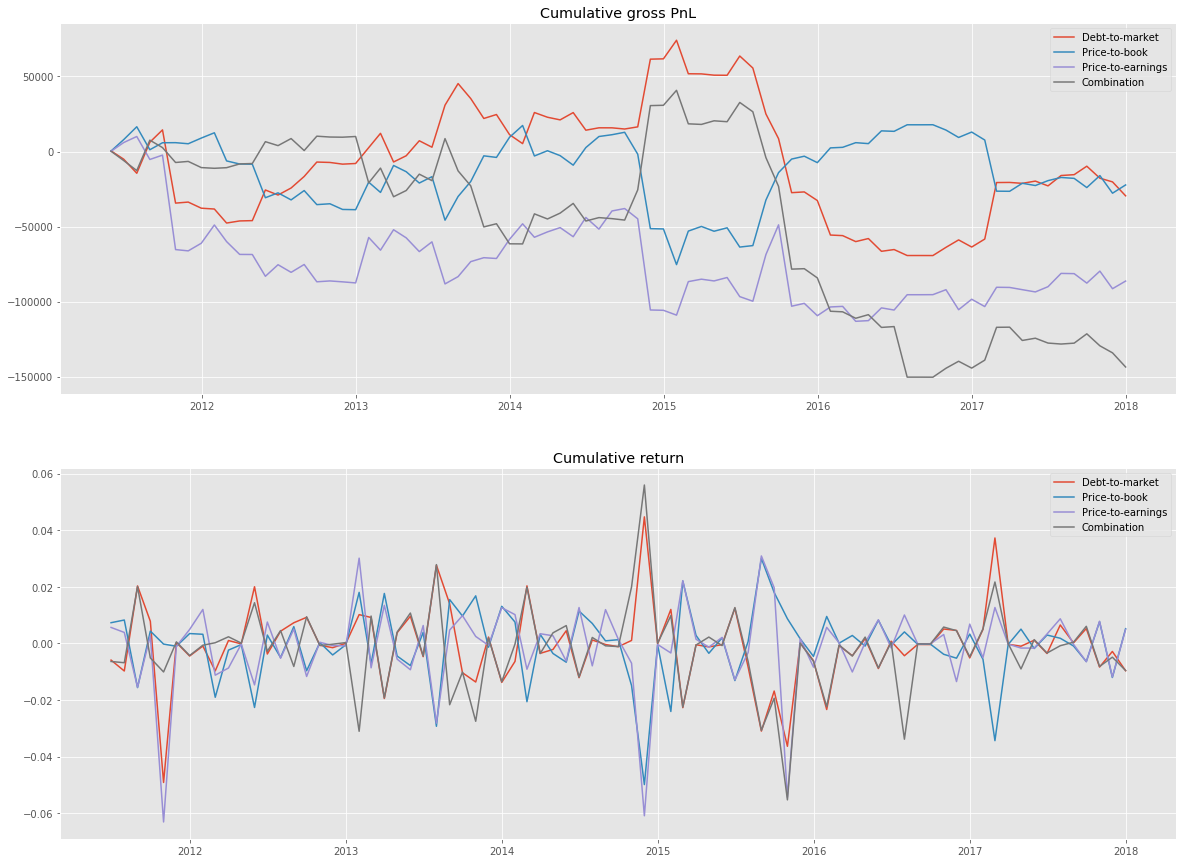

In [597]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
ax1.plot(dtm_change_returns_df[['cum_gross_pnl']], label="Debt-to-market")
ax1.plot(ptb_change_returns_df[['cum_gross_pnl']], label="Price-to-book")
ax1.plot(pte_change_returns_df[['cum_gross_pnl']], label="Price-to-earnings")
ax1.plot(combo_change_returns_df[['cum_gross_pnl']], label="Combination")
ax1.set_title("Cumulative gross PnL")
ax1.legend()

ax2.plot(np.cumprod(1+(dtm_change_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Debt-to-market")
ax2.plot(np.cumprod(1+(ptb_change_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Price-to-book")
ax2.plot(np.cumprod(1+(pte_change_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Price-to-earnings")
ax2.plot(np.cumprod(1+(combo_change_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Combination")
ax2.set_title("Cumulative return")
ax2.legend()

plt.show()

In [594]:
pd.concat([dtm_change_stats, ptb_change_stats, pte_change_stats, combo_change_stats], axis=1)

,debt-to-market,price-to-book,price-to-earnings,combination
vol,0.018675,0.017642,0.023078,0.028098
sharpe_ratio,-0.088894,-0.084529,-0.059961,-0.048007
max_drawdown,-81121.676200,-67956.970243,-91064.318014,-111164.154532
cum_profit,-29527.335056,-22284.000568,-86350.159398,25295.148841


In [676]:
dtm_change_v_returns_df = strategy(debt_to_marketcap.pct_change(), stocks_adj_close_df, 
                                   monthly_spy_adj_close, rolling_betas, True)
ptb_change_v_returns_df = strategy(price_to_book.pct_change(), stocks_adj_close_df, 
                                   monthly_spy_adj_close, rolling_betas, True)
pte_change_v_returns_df = strategy(price_to_earnings.pct_change(), stocks_adj_close_df, 
                                   monthly_spy_adj_close, rolling_betas, True)

In [677]:
dtm_change_v_stats = stats(dtm_change_v_returns_df, 'debt-to-market')
ptb_change_v_stats = stats(ptb_change_v_returns_df, 'price-to-book')
pte_change_v_stats = stats(pte_change_v_returns_df, 'price-to-earnings')

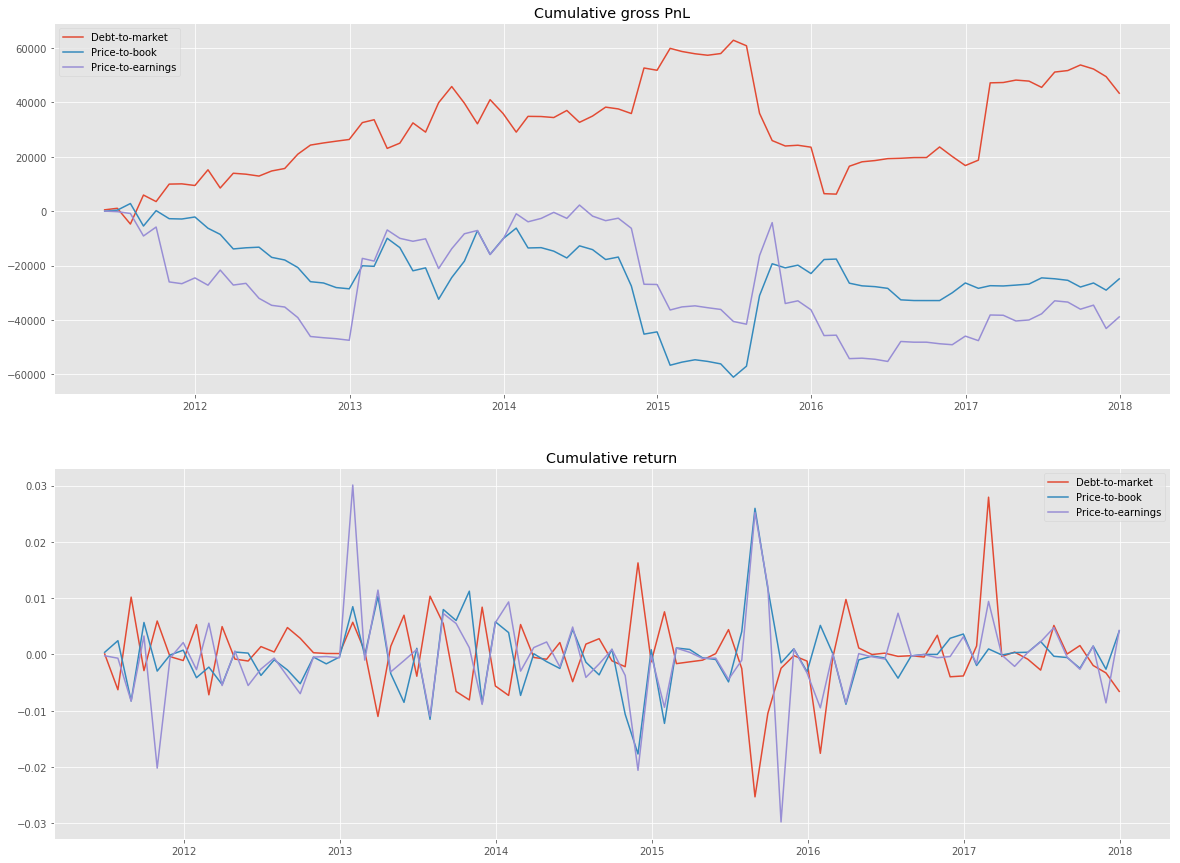

In [678]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
ax1.plot(dtm_change_v_returns_df[['cum_gross_pnl']], label="Debt-to-market")
ax1.plot(ptb_change_v_returns_df[['cum_gross_pnl']], label="Price-to-book")
ax1.plot(pte_change_v_returns_df[['cum_gross_pnl']], label="Price-to-earnings")
ax1.set_title("Cumulative gross PnL")
ax1.legend()

ax2.plot(np.cumprod(1+(dtm_change_v_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Debt-to-market")
ax2.plot(np.cumprod(1+(ptb_change_v_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Price-to-book")
ax2.plot(np.cumprod(1+(pte_change_v_returns_df[['gross_pnl']].fillna(0) + total_cap).pct_change()) - 1, label="Price-to-earnings")
ax2.set_title("Cumulative return")
ax2.legend()

plt.show()

In [679]:
pd.concat([dtm_change_v_stats, ptb_change_v_stats, pte_change_v_stats], axis=1)

,debt-to-market,price-to-book,price-to-earnings
vol,0.009326,0.007875,0.011572
sharpe_ratio,-0.187635,-0.206522,-0.137347
max_drawdown,-41572.951685,-34803.568008,-59844.570930
cum_profit,43351.376108,-24907.223318,-38886.405638


In [621]:
def beta_regression(strategy_df, spy_df):
    strategy_returns = (strategy_df[['gross_pnl']].fillna(0) + total_cap).pct_change()
    spy_returns = spy_df.pct_change()
    
    data = pd.concat([strategy_returns, spy_returns], axis=1).dropna()
    model = sm.OLS(data.iloc[:,0], sm.add_constant(data.iloc[:,1])).fit()
    
    y_pred = model.predict(sm.add_constant(data.iloc[:,1]))
    beta = model.params[1]
    
    return data.iloc[:,1], data.iloc[:,0], y_pred, beta 

In [708]:
X1, Y1, Y_pred1, beta1 = beta_regression(dtm_returns_df, monthly_spy_adj_close)
X2, Y2, Y_pred2, beta2 = beta_regression(ptb_returns_df, monthly_spy_adj_close)
X3, Y3, Y_pred3, beta3 = beta_regression(pte_returns_df, monthly_spy_adj_close)
X4, Y4, Y_pred4, beta4 = beta_regression(combo_returns_df, monthly_spy_adj_close)

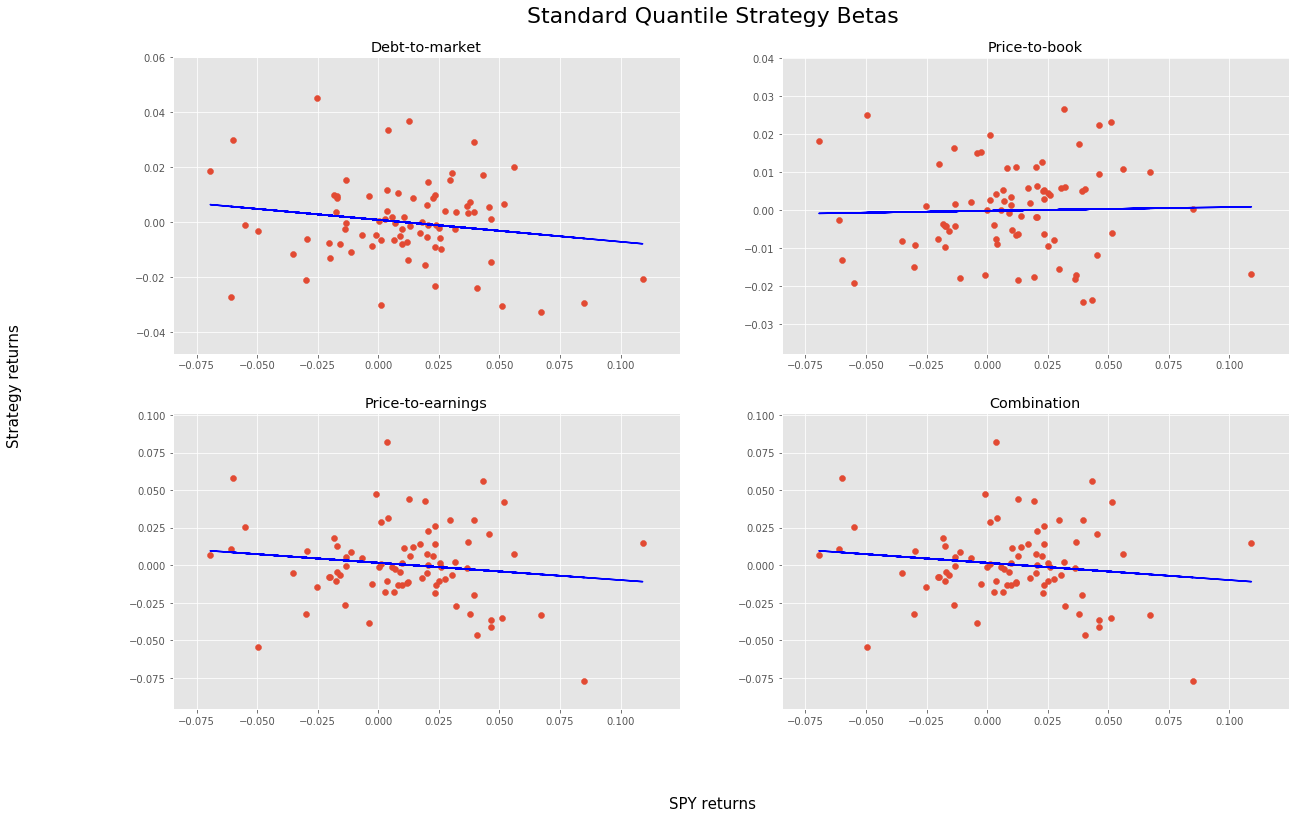

In [709]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

fig.text(0.5, 0.92, 'Standard Quantile Strategy Betas', ha='center',fontsize = 22)
fig.text(0.5, 0.01, 'SPY returns', ha='center', fontsize=15)
fig.text(0.01, 0.5, 'Strategy returns', va='center', rotation='vertical', fontsize=15)

ax[0,0].scatter(X1, Y1)
ax[0,0].plot(X1, Y_pred1, color='b')
ax[0,0].set_title("Debt-to-market")

ax[0,1].scatter(X2, Y2)
ax[0,1].plot(X2, Y_pred2, color='b')
ax[0,1].set_title("Price-to-book")

ax[1,0].scatter(X, Y)
ax[1,0].plot(X, Y_pred, color='b')
ax[1,0].set_title("Price-to-earnings")

ax[1,1].scatter(X, Y)
ax[1,1].plot(X, Y_pred, color='b')
ax[1,1].set_title("Combination")

plt.show()

In [710]:
betas_df = pd.DataFrame({beta1,beta2,beta3,beta4}).T
betas_df.columns = ["Debt-to-market","Price-to-book","Price-to-earnings","Combination"]
betas_df.index = ['Strategy beta']
betas_df

,Debt-to-market,Price-to-book,Price-to-earnings,Combination
Strategy beta,-0.079837,0.009732,0.198139,-0.115025


In [711]:
X1, Y1, Y_pred1, beta1 = beta_regression(dtm_v_returns_df, monthly_spy_adj_close)
X2, Y2, Y_pred2, beta2 = beta_regression(ptb_v_returns_df, monthly_spy_adj_close)
X3, Y3, Y_pred3, beta3 = beta_regression(pte_v_returns_df, monthly_spy_adj_close)

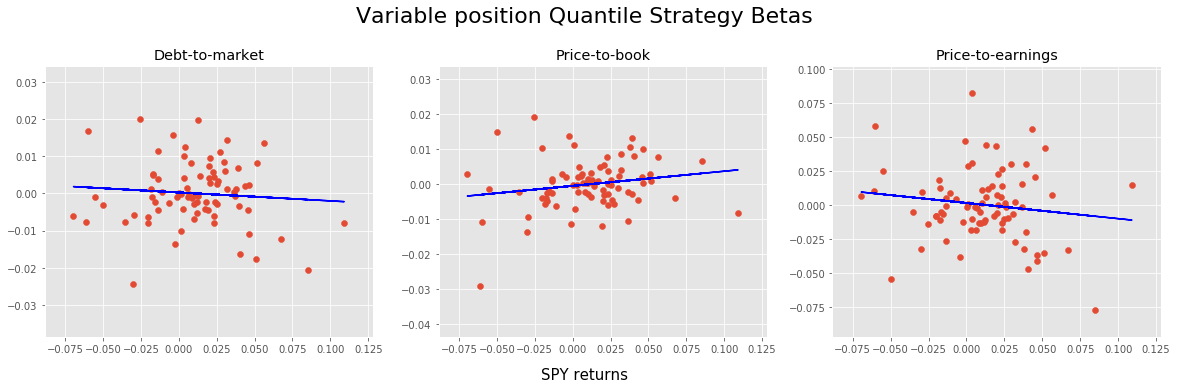

In [706]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

fig.text(0.5, 1, 'Variable position Quantile Strategy Betas', ha='center',fontsize = 22)
fig.text(0.5, 0.01, 'SPY returns', ha='center', fontsize=15)
# fig.text(0.01, 0.5, 'Strategy returns', va='center', rotation='vertical', fontsize=15)

ax[0].scatter(X1, Y1)
ax[0].plot(X1, Y_pred1, color='b')
ax[0].set_title("Debt-to-market")

ax[1].scatter(X2, Y2)
ax[1].plot(X2, Y_pred2, color='b')
ax[1].set_title("Price-to-book")

ax[2].scatter(X, Y)
ax[2].plot(X, Y_pred, color='b')
ax[2].set_title("Price-to-earnings")

plt.show()

In [712]:
betas_df = pd.DataFrame({beta1,beta2,beta3}).T
betas_df.columns = ["Debt-to-market","Price-to-book","Price-to-earnings"]
betas_df.index = ['Strategy beta']
betas_df

,Debt-to-market,Price-to-book,Price-to-earnings
Strategy beta,-0.022644,0.041802,0.101818


In [702]:
X1, Y1, Y_pred1, beta1 = beta_regression(dtm_change_returns_df , monthly_spy_adj_close)
X2, Y2, Y_pred2, beta2 = beta_regression(ptb_change_returns_df, monthly_spy_adj_close)
X3, Y3, Y_pred3, beta3 = beta_regression(pte_change_returns_df, monthly_spy_adj_close)
X4, Y4, Y_pred4, beta4 = beta_regression(combo_change_returns_df, monthly_spy_adj_close)

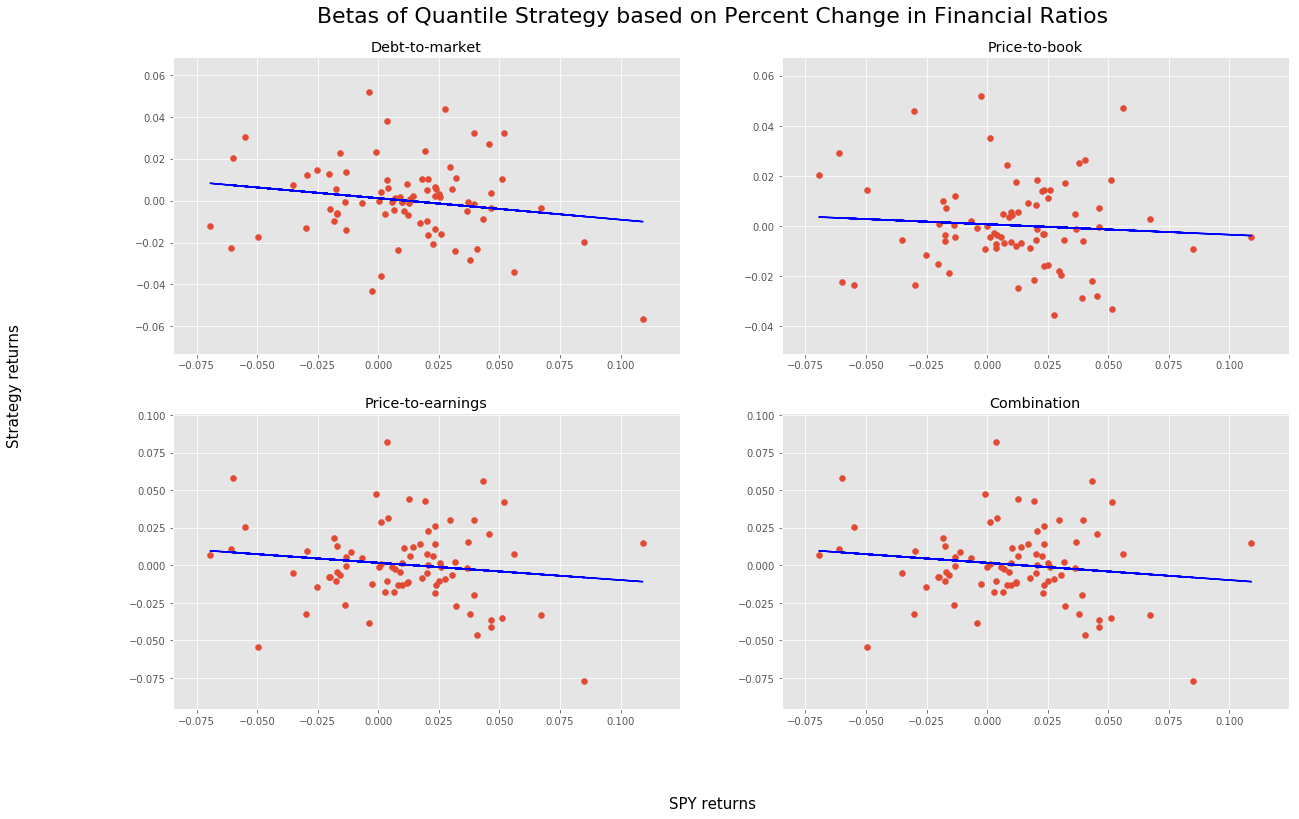

In [703]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

fig.text(0.5, 0.92, 'Betas of Quantile Strategy based on Percent Change in Financial Ratios', ha='center',fontsize = 22)
fig.text(0.5, 0.01, 'SPY returns', ha='center', fontsize=15)
fig.text(0.01, 0.5, 'Strategy returns', va='center', rotation='vertical', fontsize=15)

ax[0,0].scatter(X1, Y1)
ax[0,0].plot(X1, Y_pred1, color='b')
ax[0,0].set_title("Debt-to-market")

ax[0,1].scatter(X2, Y2)
ax[0,1].plot(X2, Y_pred2, color='b')
ax[0,1].set_title("Price-to-book")

ax[1,0].scatter(X, Y)
ax[1,0].plot(X, Y_pred, color='b')
ax[1,0].set_title("Price-to-earnings")

ax[1,1].scatter(X, Y)
ax[1,1].plot(X, Y_pred, color='b')
ax[1,1].set_title("Combination")

plt.show()

In [704]:
betas_df = pd.DataFrame({beta1,beta2,beta3,beta4}).T
betas_df.columns = ["Debt-to-market","Price-to-book","Price-to-earnings","Combination"]
betas_df.index = ['Strategy beta']
betas_df

,Debt-to-market,Price-to-book,Price-to-earnings,Combination
Strategy beta,-0.102554,-0.204353,-0.042161,-0.041537


In [697]:
X1, Y1, Y_pred1, beta1 = beta_regression(dtm_change_v_returns_df , monthly_spy_adj_close)
X2, Y2, Y_pred2, beta2 = beta_regression(ptb_change_v_returns_df, monthly_spy_adj_close)
X3, Y3, Y_pred3, beta3 = beta_regression(pte_change_v_returns_df, monthly_spy_adj_close)

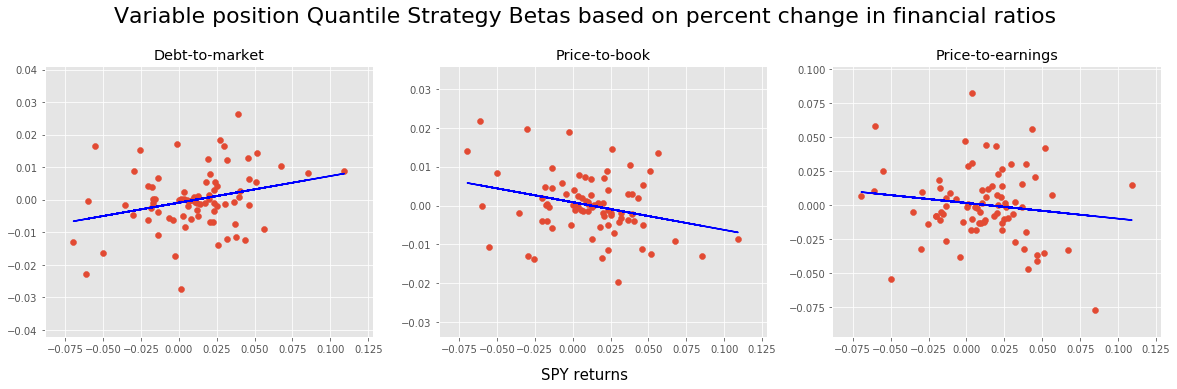

In [700]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

fig.text(0.5, 1, 'Variable position Quantile Strategy Betas based on percent change in financial ratios', ha='center',fontsize = 22)
fig.text(0.5, 0.01, 'SPY returns', ha='center', fontsize=15)
# fig.text(0.01, 0.5, 'Strategy returns', va='center', rotation='vertical', fontsize=15)

ax[0].scatter(X1, Y1)
ax[0].plot(X1, Y_pred1, color='b')
ax[0].set_title("Debt-to-market")

ax[1].scatter(X2, Y2)
ax[1].plot(X2, Y_pred2, color='b')
ax[1].set_title("Price-to-book")

ax[2].scatter(X, Y)
ax[2].plot(X, Y_pred, color='b')
ax[2].set_title("Price-to-earnings")

plt.show()

In [701]:
betas_df = pd.DataFrame({beta1,beta2,beta3}).T
betas_df.columns = ["Debt-to-market","Price-to-book","Price-to-earnings"]
betas_df.index = ['Strategy beta']
betas_df

,Debt-to-market,Price-to-book,Price-to-earnings
Strategy beta,0.082011,-0.093784,-0.071271
